# Proof of Concept
Neste notebooks tem os um prova de conceito encima do tema do TCC:
<br/>
**ANÁLISE COMPARATIVA DE TÉCNICAS PARA A PREVISÃO DE SÉRIES TEMPORAIS NO CONTEXTO DE MERCADOS FINANCEIROS**

#### Métodos Comparados
- AR
- ARMA
- ARIMA
- ARIMA-GARCH
- VAR
- 

## Imports

In [1391]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
import statistics

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# statsmodels
import statsmodels.api as sm


# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import os

## Prepare Principal Directory

In [1392]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [1393]:
prepare_directory_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/tcc'

## Cell Format

In [1394]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1395]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

## Load Data

In [1396]:
%%time

df_vale3_cleansing = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                              encoding='utf8',
                              delimiter=',',
                              verbose=True)

Tokenization took: 0.23 ms
Type conversion took: 0.75 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 2.23 ms, sys: 1.41 ms, total: 3.64 ms
Wall time: 3.13 ms


In [1397]:
print(df_vale3_cleansing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2495 non-null   object 
 1   price   2495 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.1+ KB
None


In [1398]:
df_vale3_cleansing.head()

,date,price
0,2020-06-19,55.170000
1,2020-06-18,56.170000
2,2020-06-17,56.200000
3,2020-06-16,55.390000
4,2020-06-15,53.880000


## Format Date

In [1399]:
df_vale3_cleansing['date'] = pd.to_datetime(df_vale3_cleansing['date'],
                                            format='%Y/%m/%d',
                                           errors='raise')

In [1400]:
df_vale3_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2495 non-null   datetime64[ns]
 1   price   2495 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.1 KB


## Convert the data frame index to a datetime index 

In [1401]:
df_vale3_cleansing = df_vale3_cleansing.reset_index(drop=True, level=0)
df_vale3_cleansing.index.names = ['date']
df_vale3_cleansing.index = df_vale3_cleansing['date']

print(type(df_vale3_cleansing.index))
print(type(df_vale3_cleansing.index[0]))
print(df_vale3_cleansing.index)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
DatetimeIndex(['2020-06-19', '2020-06-18', '2020-06-17', '2020-06-16',
               '2020-06-15', '2020-06-12', '2020-06-10', '2020-06-09',
               '2020-06-08', '2020-06-05',
               ...
               '2010-06-02', '2010-06-01', '2010-05-31', '2010-05-28',
               '2010-05-27', '2010-05-26', '2010-05-25', '2010-05-24',
               '2010-05-21', '2010-05-20'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)


In [1402]:
df_vale3_cleansing.head()

,date,price
date,,
2020-06-19,2020-06-19,55.170000
2020-06-18,2020-06-18,56.170000
2020-06-17,2020-06-17,56.200000
2020-06-16,2020-06-16,55.390000
2020-06-15,2020-06-15,53.880000


In [1403]:
df_vale3_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2495 entries, 2020-06-19 to 2010-05-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2495 non-null   datetime64[ns]
 1   price   2495 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 58.5 KB


In [1404]:
#df_vale3_cleansing.drop(['date'], axis=1, inplace=True)
df_vale3_cleansing.head(1)

,date,price
date,,
2020-06-19,2020-06-19,55.170000


## Train and Test

In [1405]:
size_train = int(len(df_vale3_cleansing['price'])*0.8)
size_test = int(len(df_vale3_cleansing['price'])*0.2)

print(size_train)
print(size_test)

train = df_vale3_cleansing['price'].iloc[size_test:]
test = df_vale3_cleansing['price'].iloc[:size_test]

1996
499


Text(0.5, 1.0, 'Train size: 1996')

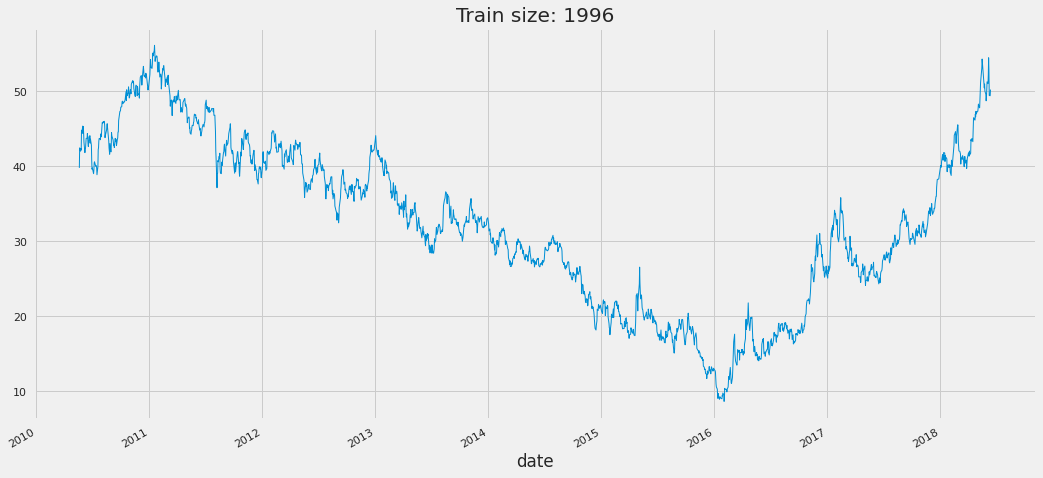

In [1406]:
train.plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(train)}')

Text(0.5, 1.0, 'Test size: 499')

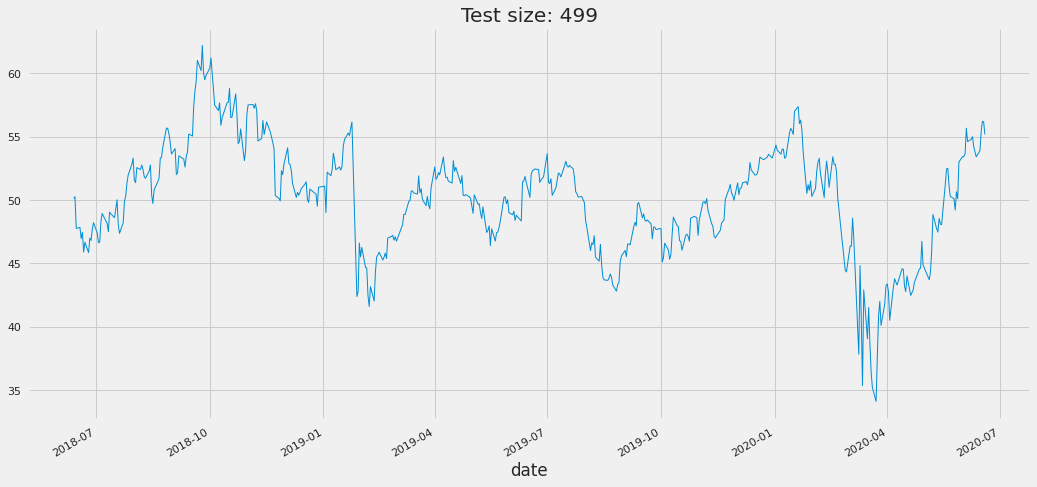

In [1407]:
test.plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(test)}')

## Metric to Evaluation

In [1408]:
# Function for mean_absolute_percentage_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Statistic Models

#### AR

In [1409]:
data = sm.datasets.sunspots.load()


from datetime import datetime
dates = sm.tsa.datetools.dates_from_range('1700', length=len(data.endog))
print(type(dates[0]))
endog = pd.Series(data.endog, index=dates)
print(endog[0])

ar_model = sm.tsa.AR(endog, freq='A')
pandas_ar_res = ar_model.fit(maxlag=9, method='mle', disp=-1)

pred = pandas_ar_res.predict(start='2005', end='2015')
print(pred)

<class 'datetime.datetime'>
5.0
2005-12-31   20.003294
2006-12-31   24.703973
2007-12-31   20.026125
2008-12-31   23.473635
2009-12-31   30.858588
2010-12-31   61.335473
2011-12-31   87.024717
2012-12-31   91.321290
2013-12-31   79.921673
2014-12-31   60.799579
2015-12-31   40.374930
Freq: A-DEC, dtype: float64


In [1410]:
df_vale3_cleansing.head()

,date,price
date,,
2020-06-19,2020-06-19,55.170000
2020-06-18,2020-06-18,56.170000
2020-06-17,2020-06-17,56.200000
2020-06-16,2020-06-16,55.390000
2020-06-15,2020-06-15,53.880000


In [1411]:
mod = sm.tsa.statespace.SARIMAX(df_vale3_cleansing['price'],
                                trend='n',
                                order=(1,0,0),
                                seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                price   No. Observations:                 2495
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -3318.718
Date:                              Sun, 21 Jun 2020   AIC                           6645.437
Time:                                      19:03:37   BIC                           6668.706
Sample:                                           0   HQIC                          6653.887
                                             - 2495                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9980      0.002    495.066      0.000       0.994       1.002
ar.S.L12      -0.02

In [1428]:
df_vale3_cleansing['forecast'] = results.predict(start='2020-06-18',
                                                 end='2010-06-18',
                                                 dynamic=False)  

Text(0.5, 1.0, 'Train and Test')

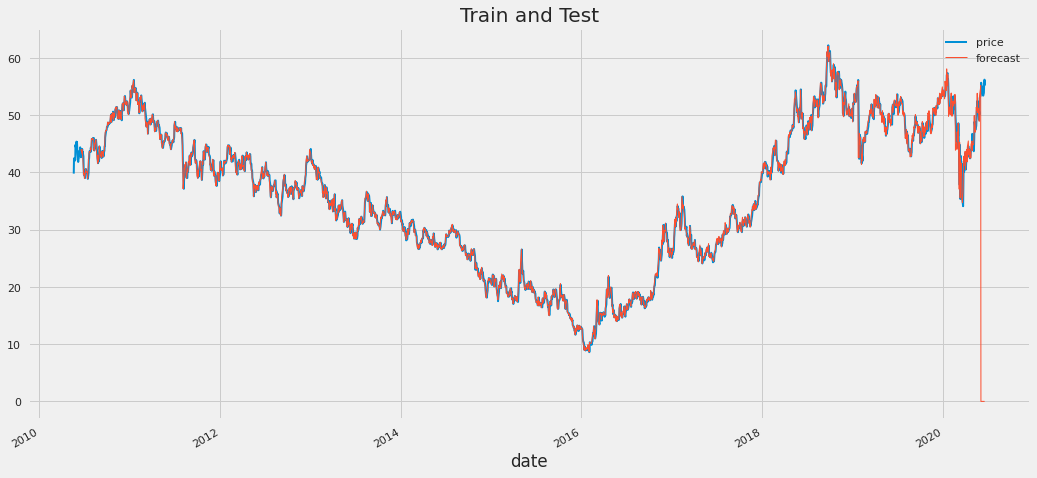

In [1430]:
df_vale3_cleansing['price'].plot(linewidth=2)
df_vale3_cleansing['forecast'].plot(linewidth=1)
plt.legend()
plt.title('Train and Test')

In [1431]:
mape = mean_absolute_percentage_error(y_true=df_vale3_cleansing['price'],
                               y_pred=results.fittedvalues.shift(-1))

In [1432]:
mape

0.800680974976406

In [1433]:
df_vale3_cleansing[:size_train]

,date,price,forecast
date,,,
2020-06-19,2020-06-19,55.170000,nan
2020-06-18,2020-06-18,56.170000,0.000496
2020-06-17,2020-06-17,56.200000,0.000953
2020-06-16,2020-06-16,55.390000,0.001363
2020-06-15,2020-06-15,53.880000,0.001717
2020-06-12,2020-06-12,53.400000,0.002011
2020-06-10,2020-06-10,54.200000,0.002255
2020-06-09,2020-06-09,54.990000,0.002460
2020-06-08,2020-06-08,54.780000,0.002626
